In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgbm
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import QuantileTransformer

In [2]:
matches = pd.read_pickle('../Resources/tennis_clean/atp_matches_full_feature.pkl').reset_index()

In [3]:
CAREER_COLUMNS = ['career_first_serve_percentage',
                  'career_first_serves_won_percentage',
                  'career_second_serves_won_percentage',
                  'career_service_points_won_percentage',
                  'career_break_points_saved_percentage',
                  'career_break_points_won_percentage',
                  'career_first_serve_return_points_won_percentage',
                  'career_second_serve_return_points_won_percentage',
                  'career_return_points_won_percentage',
                  'career_points_won_percentage',
                  'career_ace_rate',
                  'career_double_fault_rate']


CAREER_COLUMNS += [column + '_opponent' for column in CAREER_COLUMNS]

In [4]:
EWMA_10_COLUMNS = ['ewma_10_first_serve_percentage',
                   'ewma_10_first_serves_won_percentage',
                   'ewma_10_second_serves_won_percentage',
                   'ewma_10_service_points_won_percentage',
                   'ewma_10_break_points_saved_percentage',
                   'ewma_10_break_points_won_percentage',
                   'ewma_10_first_serve_return_points_won_percentage',
                   'ewma_10_second_serve_return_points_won_percentage',
                   'ewma_10_return_points_won_percentage',
                   'ewma_10_points_won_percentage',
                   'ewma_10_ace_rate',
                   'ewma_10_double_fault_rate']

EWMA_10_COLUMNS += [column + '_opponent' for column in EWMA_10_COLUMNS]

In [5]:
EWMA_50_COLUMNS = ['ewma_50_first_serve_percentage',
                   'ewma_50_first_serves_won_percentage',
                   'ewma_50_second_serves_won_percentage',
                   'ewma_50_service_points_won_percentage',
                   'ewma_50_break_points_saved_percentage',
                   'ewma_50_break_points_won_percentage',
                   'ewma_50_first_serve_return_points_won_percentage',
                   'ewma_50_second_serve_return_points_won_percentage',
                   'ewma_50_return_points_won_percentage',
                   'ewma_50_points_won_percentage',
                   'ewma_50_ace_rate',
                   'ewma_50_double_fault_rate']

EWMA_50_COLUMNS += [column + '_opponent' for column in EWMA_50_COLUMNS]

In [6]:
OTHER_COLUMNS = ['ranking_points_diff', 'rank_diff', 'player_age', 'opponent_age', 'result_value']

In [7]:
COLUMNS = CAREER_COLUMNS + EWMA_10_COLUMNS + EWMA_50_COLUMNS + OTHER_COLUMNS

In [8]:
train = matches[(matches['tournament_date'] > '2009') & (matches['tournament_date'] < '2021')][COLUMNS]
test = matches[matches['tournament_date'] > '2021'][COLUMNS]

In [9]:
X_train = train.drop('result_value', axis=1)
y_train = train['result_value']

X_test = test.drop('result_value', axis=1)
y_test = test['result_value']

In [11]:
def objective_lgbm(trial):
    params = {
        'objective': 'binary',
        'num_threads': -1,
        'num_trees': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 10, 50),
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'subsample_freq': 1,
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50)
    }
    
    lgb = lgbm.LGBMClassifier(**params)
    
    score = cross_val_score(lgb, X_train, y_train, scoring='accuracy', n_jobs=-1, cv=5)
    log_loss = score.mean()
    return log_loss

In [12]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_lgbm, n_trials=100)
print(study.best_trial, study.best_params)

[I 2021-08-31 08:56:41,804] A new study created in memory with name: no-name-604cfc88-c355-4088-902e-bd516022a794
[I 2021-08-31 08:56:59,308] Trial 0 finished with value: 0.6480934877747793 and parameters: {'learning_rate': 0.02760598546051073, 'lambda_l1': 7.836230301318764, 'lambda_l2': 8.006366355587524, 'num_leaves': 20, 'max_depth': 7, 'feature_fraction': 0.7147775616299628, 'subsample': 0.6172524399711191, 'min_data_in_leaf': 32}. Best is trial 0 with value: 0.6480934877747793.
[I 2021-08-31 08:57:10,867] Trial 1 finished with value: 0.653830817457836 and parameters: {'learning_rate': 0.019622500789360765, 'lambda_l1': 2.4656365410114054, 'lambda_l2': 0.06801867332228206, 'num_leaves': 11, 'max_depth': 7, 'feature_fraction': 0.6343505595728025, 'subsample': 0.6559104486493712, 'min_data_in_leaf': 33}. Best is trial 1 with value: 0.653830817457836.
[I 2021-08-31 08:57:30,833] Trial 2 finished with value: 0.6316563214807747 and parameters: {'learning_rate': 0.053232235175356676, 'l

[I 2021-08-31 09:02:54,942] Trial 21 finished with value: 0.6591457714972127 and parameters: {'learning_rate': 0.005218513867905072, 'lambda_l1': 1.1464443879000368, 'lambda_l2': 6.995326024498544, 'num_leaves': 35, 'max_depth': 6, 'feature_fraction': 0.7569202235588247, 'subsample': 0.7624541666531933, 'min_data_in_leaf': 24}. Best is trial 11 with value: 0.6604128922339949.
[I 2021-08-31 09:03:05,893] Trial 22 finished with value: 0.6555027113043513 and parameters: {'learning_rate': 0.016199362326721048, 'lambda_l1': 1.2565379651005473, 'lambda_l2': 7.3353601019372885, 'num_leaves': 40, 'max_depth': 4, 'feature_fraction': 0.7932000955354658, 'subsample': 0.5774365321325475, 'min_data_in_leaf': 29}. Best is trial 11 with value: 0.6604128922339949.
[I 2021-08-31 09:03:26,473] Trial 23 finished with value: 0.6578786043034921 and parameters: {'learning_rate': 0.006097736455735607, 'lambda_l1': 0.6549514346299254, 'lambda_l2': 5.814729107275474, 'num_leaves': 32, 'max_depth': 7, 'feature_

[I 2021-08-31 09:08:47,712] Trial 42 finished with value: 0.6616975365279292 and parameters: {'learning_rate': 0.005030883557043383, 'lambda_l1': 8.095865647115192, 'lambda_l2': 8.035458772624818, 'num_leaves': 41, 'max_depth': 5, 'feature_fraction': 0.5254380762858255, 'subsample': 0.7681359049840146, 'min_data_in_leaf': 5}. Best is trial 42 with value: 0.6616975365279292.
[I 2021-08-31 09:08:58,750] Trial 43 finished with value: 0.6588464757689126 and parameters: {'learning_rate': 0.011129422288297296, 'lambda_l1': 9.91308392381202, 'lambda_l2': 8.007844720920748, 'num_leaves': 47, 'max_depth': 4, 'feature_fraction': 0.5608579656637575, 'subsample': 0.7104545477984587, 'min_data_in_leaf': 1}. Best is trial 42 with value: 0.6616975365279292.
[I 2021-08-31 09:09:12,496] Trial 44 finished with value: 0.65342603660528 and parameters: {'learning_rate': 0.01666569425172844, 'lambda_l1': 8.356668670597681, 'lambda_l2': 9.00258288281231, 'num_leaves': 39, 'max_depth': 5, 'feature_fraction': 

[I 2021-08-31 09:12:49,065] Trial 64 finished with value: 0.662841518503876 and parameters: {'learning_rate': 0.005028651352273082, 'lambda_l1': 5.276293990386554, 'lambda_l2': 9.194957193381985, 'num_leaves': 15, 'max_depth': 4, 'feature_fraction': 0.5274711818746765, 'subsample': 0.9727211892034757, 'min_data_in_leaf': 15}. Best is trial 62 with value: 0.6630878920365529.
[I 2021-08-31 09:12:59,982] Trial 65 finished with value: 0.6624719334278266 and parameters: {'learning_rate': 0.0054480492010563234, 'lambda_l1': 5.313405400469158, 'lambda_l2': 9.16347646457041, 'num_leaves': 18, 'max_depth': 4, 'feature_fraction': 0.4705928141160549, 'subsample': 0.9974613157505053, 'min_data_in_leaf': 15}. Best is trial 62 with value: 0.6630878920365529.
[I 2021-08-31 09:13:14,358] Trial 66 finished with value: 0.6620319660901515 and parameters: {'learning_rate': 0.0051141904602171676, 'lambda_l1': 5.135131827096218, 'lambda_l2': 9.560318750105655, 'num_leaves': 18, 'max_depth': 5, 'feature_frac

[I 2021-08-31 09:17:08,712] Trial 85 finished with value: 0.6597968809740719 and parameters: {'learning_rate': 0.008619333311129879, 'lambda_l1': 5.456848153831531, 'lambda_l2': 9.827330881568418, 'num_leaves': 13, 'max_depth': 5, 'feature_fraction': 0.5621370149437812, 'subsample': 0.9879255116798292, 'min_data_in_leaf': 22}. Best is trial 62 with value: 0.6630878920365529.
[I 2021-08-31 09:17:22,309] Trial 86 finished with value: 0.6594977137766348 and parameters: {'learning_rate': 0.007360620750343117, 'lambda_l1': 4.941164012216847, 'lambda_l2': 9.734678867076461, 'num_leaves': 15, 'max_depth': 6, 'feature_fraction': 0.5346691347224354, 'subsample': 0.995704725402928, 'min_data_in_leaf': 19}. Best is trial 62 with value: 0.6630878920365529.
[I 2021-08-31 09:17:34,306] Trial 87 finished with value: 0.6588641402454445 and parameters: {'learning_rate': 0.010984481406515173, 'lambda_l1': 5.391222940926068, 'lambda_l2': 9.969732838593698, 'num_leaves': 18, 'max_depth': 4, 'feature_fract

FrozenTrial(number=62, values=[0.6630878920365529], datetime_start=datetime.datetime(2021, 8, 31, 9, 12, 15, 694776), datetime_complete=datetime.datetime(2021, 8, 31, 9, 12, 26, 642561), params={'learning_rate': 0.00525183006449468, 'lambda_l1': 6.202993277707203, 'lambda_l2': 9.146651353459728, 'num_leaves': 15, 'max_depth': 4, 'feature_fraction': 0.46853860449820206, 'subsample': 0.9868627629547556, 'min_data_in_leaf': 11}, distributions={'learning_rate': UniformDistribution(high=0.1, low=0.005), 'lambda_l1': UniformDistribution(high=10.0, low=0.0), 'lambda_l2': UniformDistribution(high=10.0, low=0.0), 'num_leaves': IntUniformDistribution(high=50, low=10, step=1), 'max_depth': IntUniformDistribution(high=8, low=4, step=1), 'feature_fraction': UniformDistribution(high=1.0, low=0.4), 'subsample': UniformDistribution(high=1.0, low=0.4), 'min_data_in_leaf': IntUniformDistribution(high=50, low=1, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=62, state=TrialSta

In [47]:
best_params_lgb = {
    'objective': 'binary',
    'metric': ['binary', 'auc'],
    'num_threads': -1,
    'num_trees': 500,
    'learning_rate': 0.03,
    'lambda_l1': 6.2,
    'lambda_l2': 9.15,
    'num_leaves': 15,
    'max_depth': 4,
    'feature_fraction': 0.5,
    'min_data_in_leaf': 11
}

lgb = lgbm.LGBMClassifier(**best_params_lgb).fit(X_train, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] num_iterations is set=500, num_trees=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l1 is set=6.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.2
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=9.15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.15


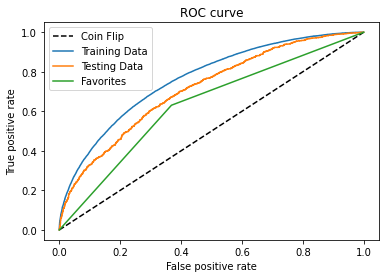

Train AUC: 0.7645790573434164
Test AUC: 0.7129958897960329
Favorite AUC: 0.6311162079510704

Test Accuracy: 0.6517584097859327
Test Accuracy: 0.6311162079510704


In [48]:
y_pred_train = lgb.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)

y_pred_test = lgb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_test)


plt.plot([0, 1], [0, 1], 'k--', label='Coin Flip')
plt.plot(fpr_train, tpr_train, label='Training Data')
plt.plot(fpr, tpr, label='Testing Data')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')


higher_ranked = test.dropna(subset=COLUMNS).ranking_points_diff > 0
fpr_naive, tpr_naive, _ = roc_curve(y_test, higher_ranked.values)
plt.plot(fpr_naive, tpr_naive, label='Favorites')


plt.legend()
plt.show()

print(f'Train AUC: {roc_auc_score(y_train, y_pred_train)}')
print(f'Test AUC: {roc_auc_score(y_test, y_pred_test)}')
print(f'Favorite AUC: {roc_auc_score(y_test, higher_ranked)}')

print(f'\nTest Accuracy: {accuracy_score(y_test, lgb.predict(X_test))}')
print(f'Test Accuracy: {accuracy_score(y_test, higher_ranked)}')